In [10]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import os
import sys
import plotly.graph_objects as go

from importlib import reload

sys.path.append('')
import deck_load

import inspect

import warnings
warnings.filterwarnings("ignore")
import plot_type

import signal_to_noise as sn

In [29]:
import statsmodels.api as sm 

In [30]:
lowess = sm.nonparametric.lowess

In [3]:
ipsl = deck_load.Deck('IPSL','IPSL-CM6A-LR','r1i1p1f1','ts')

In [4]:
# The anomalies based upon the 1850 to 1900 climatology,
ipsl_anom = ipsl.anomalies()
ipsl_anom

Weighted Space mean of DECK data for IPSL IPSL-CM6A-LR 
**** ENS: r1i1p1f1 
**** VAR: ts
Time frame: 1850 - 3849


In [5]:
# The space mean of the anomaies (smean)
ipsl_anom_smean = ipsl_anom.space_mean()
ipsl_anom_smean

<xarray.DataArray 'ts' (scenario: 4, time: 2000)>
dask.array<truediv, shape=(4, 2000), dtype=float32, chunksize=(1, 8), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 3849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [150]:
# PUtting the space mean anomalies into memory, so each time I use the data it doesn't have to be
# recalcualted.
ipsl_anom_smean = ipsl_anom_smean.compute()

In [151]:
ROLL_PERIOD = 27
MIN_PERIODS = ROLL_PERIOD

In [152]:
sn = reload(sn)
ipsl_smean_signal = ipsl_anom_smean.rolling(time = ROLL_PERIOD, min_periods = MIN_PERIODS, center = True)\
        .reduce(sn.apply_along_helper, func1d = sn.grid_trend)

In [153]:
ipsl_smean_signal

<xarray.DataArray 'ts' (scenario: 4, time: 2000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 3849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

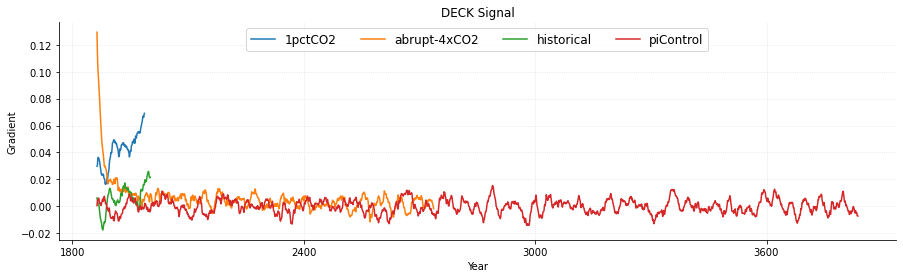

In [154]:
data = ipsl_smean_signal

fig, ax = plt.subplots(figsize = (15,4))

time = data.time.values
for scenario in data.scenario.values:
    ax.plot(time, data.sel(scenario = scenario),
                              label = scenario)

ax.set_title('DECK Signal');
ax.legend(ncol  = 4, loc = 'upper center', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Gradient')
ax.grid(alpha = 0.4, linestyle = ':')

<b> Manual Signal Calculation for time 0 </b>

In [182]:
ROLL_PERIOD

27

In [203]:
ipsl_abrupt = ipsl_anom_smean.sel(scenario = 'abrupt-4xCO2')
ipsl_abrupt = ipsl_abrupt.where(np.isfinite(ipsl_abrupt), drop = True)
y = ipsl_abrupt.values
x = np.arange(len(y))

In [205]:

fig = go.Figure(data = go.Scatter(x  = x, y = y))
fig.show()

In [210]:
x1,y1,x2,y2 = x[0],y[0],x[ROLL_PERIOD],y[ROLL_PERIOD]
print(x1,y1,x2,y2)

0 1.2165939 27 5.46072


In [211]:
dy = y2 - y1
dy

4.2441263

In [212]:
dx = x2  - x1
dx

27

In [213]:
manual_grad = dy/dx
manual_grad

0.15718986369945384

In [216]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = x[:ROLL_PERIOD + 20], y = y[:ROLL_PERIOD + 20], name = 'temp anom'))
fig.add_trace(go.Scatter(x = [x1, x2], y = [y1, y2], name = 'trend line'))

# LOESS Detrend

* https://www.statsmodels.org/stable/_modules/statsmodels/nonparametric/smoothers_lowess.html#lowess
* https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35

In [155]:
ipsl_abrupt = ipsl_anom_smean.sel(scenario = 'abrupt-4xCO2')
ipsl_abrupt = ipsl_abrupt.where(np.isfinite(ipsl_abrupt), drop = True)
y = ipsl_abrupt.values
x = np.arange(len(y))

In [156]:
step_size = 10
frac = step_size/len(y)
frac

0.011111111111111112

In [157]:
yhat = lowess(y, x, frac  = frac)

In [158]:
yhat.shape

(900, 2)

In [159]:
ipsl_abrupt_detrend_loess = ipsl_abrupt - yhat[:,1]

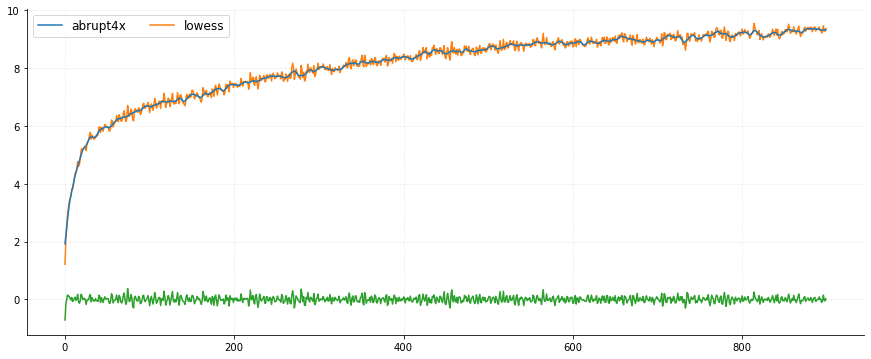

In [160]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(yhat[:,0], yhat[:,1], label  = 'abrupt4x')
ax.plot(x,y, zorder = -1, label = 'lowess')
ax.plot(x,ipsl_abrupt_detrend_loess.values)

ax.legend(ncol  = 2, loc = 'best', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha = 0.4, linestyle = ':')

In [161]:
ipsl_abrupt_detrend_loess_std =\
            ipsl_abrupt_detrend_loess.rolling(time = ROLL_PERIOD).reduce(np.std)
ipsl_abrupt_detrend_loess_std.coords

Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 2749-12-31 00:00:00
    scenario  <U12 'abrupt-4xCO2'

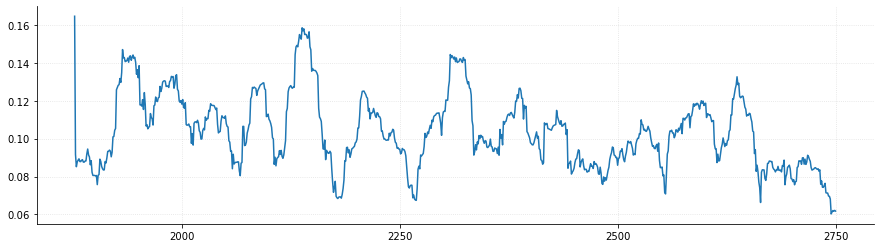

In [162]:
data = ipsl_abrupt_detrend_loess_std

fig, ax = plt.subplots(figsize = (15,4))
ax.plot(data.time.values, data.values)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha = 0.4, linestyle = ':')

In [163]:
 ipsl_smean_signal

<xarray.DataArray 'ts' (scenario: 4, time: 2000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1850-12-31 00:00:00 ... 3849-12-31 00:00:00
  * scenario  (scenario) object '1pctCO2' 'abrupt-4xCO2' ... 'piControl'

In [164]:
ipsl_abrupt_signal = ipsl_smean_signal.sel(scenario = 'abrupt-4xCO2')
ipsl_abrupt_signal = ipsl_abrupt_signal.where(
                ipsl_abrupt_signal.time.isin(ipsl_abrupt_detrend_loess_std.time.values) , 
                drop = True)

In [165]:
 ipsl_smean_sn_loess =  ipsl_abrupt_signal/ipsl_abrupt_detrend_loess_std

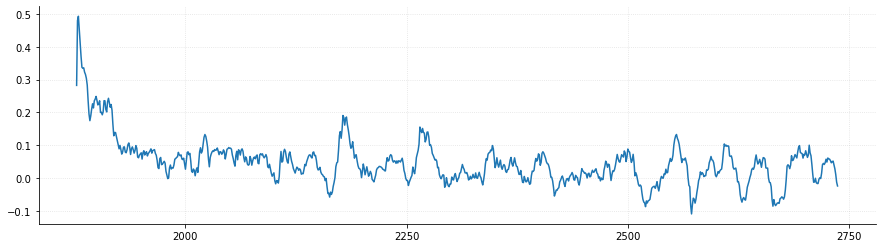

In [166]:
data =  ipsl_smean_sn_loess 

fig, ax = plt.subplots(figsize = (15,4))
ax.plot(data.time.values, data.values)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
3ax.grid(alpha = 0.4, linestyle = ':')

# Functinoal Lowess